In [2]:
# # ONLY RUN THIS IF YOU'RE IN GOOGLE COLAB
# from google.colab import drive
# import os

# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/Thesis/Pintu-Air')

# # Verify you're in the right place
# !pwd
# !ls -la

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import boxcox, boxcox_normmax, boxcox_llf, chi2
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from statsmodels.stats.diagnostic import acorr_ljungbox, lilliefors
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
import gc
import os
import time
warnings.filterwarnings('ignore')

# Functions Needed

In [4]:
def plot_acf_pacf(data, period, lag):
    fig, axes = plt.subplots(1, 2, figsize=(14, 12))

    # ACF Plot
    for lag in range(period, lag+1, period):
        axes[0].axvline(x=lag, color='red', linestyle='--', linewidth=1, zorder=0)
    plot_acf(data, ax=axes[0], lags=lag, marker='o', markersize=3)
    axes[0].set_title('Autocorrelation Function (ACF)')

    # PACF Plot
    for lag in range(period, lag+1, period):
        axes[1].axvline(x=lag, color='red', linestyle='--', linewidth=1, zorder=0)
    plot_pacf(data, ax=axes[1], lags=lag, marker='o', markersize=3)
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()

def boxcox_transformation(data):
    lambda_opt = boxcox_normmax(data, method='mle').item()

    # Log-likelihood with optimum lambda
    llf_opt = boxcox_llf(lambda_opt, data)

    # Log-likelihood if lambda = 1
    llf_null = boxcox_llf(1.0, data)

    # Calculate LRT
    lrt_stat = (2 * (llf_opt - llf_null)).item()

    # Calculate p-value (df = 1)
    p_value = chi2.sf(lrt_stat, df=1)

    print(f"Lambda optimal: {lambda_opt:.4f}")
    print(f"LRT statistic: {lrt_stat:.4f}")
    print(f"P-value: {p_value:.6f}")

    return lambda_opt

def inverse_transform(transformed_data, lambda_opt):
    if lambda_opt == 0:
        return np.exp(transformed_data)  # Log case: e^(transformed_data)
    elif lambda_opt == 1:
        return transformed_data  # No transformation case
    else:
        return np.power(transformed_data, 1/lambda_opt)
    
def modelling(order, data_y_train_trans, data_y_train, data_y_test, seasonal_order=None, exog=False, data_x_train=None, data_x_test=None, lambda_opt=1.0):
    
    # Generate model name automatically
    if seasonal_order is None:
        model_name = f"ARIMA{order}"
        if exog:
            model_name = f"ARIMAX{order}"
    else:
        model_name = f"SARIMA{order}x{seasonal_order}"
        if exog:
            model_name = f"SARIMAX{order}x{seasonal_order}"
    
    print(f"\n{'='*60}")
    print(f"Testing {model_name}")
    print(f"{'='*60}")
    
    # Start timing
    start_time = time.time()
    
    try:
        # Create model based on parameters
        if seasonal_order is None:
            # ARIMA or ARIMAX
            if exog and data_x_train is not None:
                model = SARIMAX(data_y_train_trans, exog=data_x_train, order=order)
            else:
                model = ARIMA(data_y_train_trans, order=order)
        else:
            # SARIMA or SARIMAX
            if exog and data_x_train is not None:
                model = SARIMAX(data_y_train_trans, exog=data_x_train, 
                              order=order, seasonal_order=seasonal_order)
            else:
                model = SARIMAX(data_y_train_trans, order=order, seasonal_order=seasonal_order)
        
        # Fit the model
        print("Fitting model...")
        if seasonal_order is None and not exog:
            results = model.fit()
        else:
            results = model.fit(disp=False)
        
        # Calculate training time
        training_time = time.time() - start_time
        print(f"Model fitted successfully in {training_time:.2f} seconds!")
        
        # Get residuals for diagnostic tests
        residuals = results.resid
        
        # Ljung-Box Test (test for white noise)
        ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
        ljung_box_pvalue = ljung_box_result['lb_pvalue'].iloc[0]
        
        # Lilliefors Test (test for normality)
        stat, lillie_pvalue = lilliefors(residuals)
        
        # Check if all variables are significant
        pvalues = results.pvalues
        all_significant = all(pvalues < 0.05)
        
        # Calculate training metrics
        fitted_values = results.fittedvalues
        fitted_values_transformed = inverse_transform(fitted_values, lambda_opt)
        
        rmse_train = np.sqrt(mean_squared_error(data_y_train, fitted_values_transformed))
        mae_train = mean_absolute_error(data_y_train, fitted_values_transformed)
        mape_train = mean_absolute_percentage_error(data_y_train, fitted_values_transformed) * 100
        
        # Calculate testing metrics
        if exog and data_x_test is not None:
            forecast = results.forecast(steps=len(data_y_test), exog=data_x_test)
        else:
            forecast = results.forecast(steps=len(data_y_test))
            
        forecast_transformed = inverse_transform(forecast, lambda_opt)
        
        rmse_test = np.sqrt(mean_squared_error(data_y_test, forecast_transformed))
        mae_test = mean_absolute_error(data_y_test, forecast_transformed)
        mape_test = mean_absolute_percentage_error(data_y_test, forecast_transformed) * 100
        
        # Print results
        print(f"Training RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, MAPE: {mape_train:.2f}%")
        print(f"Testing RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, MAPE: {mape_test:.2f}%")
        print(f"Ljung-Box p-value: {ljung_box_pvalue:.6f}")
        print(f"Lilliefors p-value: {lillie_pvalue:.6f}")
        
        # Create results dictionary
        results_dict = {
            'Model': model_name,
            'Semua Variabel Signifikan': 'Ya' if all_significant else 'Tidak',
            'P-value Ljung Box': f"{ljung_box_pvalue:.6f}",
            'White Noise?': 'Ya' if ljung_box_pvalue > 0.05 else 'Tidak',
            'P-value Lillie Test': f"{lillie_pvalue:.6f}",
            'Distribusi Normal?': 'Ya' if lillie_pvalue > 0.05 else 'Tidak',
            'RMSE Training': f"{rmse_train:.4f}",
            'MAE Training': f"{mae_train:.4f}",
            'MAPE Training': f"{mape_train:.2f}",
            'RMSE Testing': f"{rmse_test:.4f}",
            'MAE Testing': f"{mae_test:.4f}",
            'MAPE Testing': f"{mape_test:.2f}",
            'Training Time (seconds)': f"{training_time:.2f}"
        }
        
        print(f"Model {model_name} completed successfully!")
        
    except Exception as e:
        print(f"Error fitting {model_name}: {str(e)}")
        training_time = time.time() - start_time
        
        # Create error results
        results_dict = {
            'Model': model_name,
            'Semua Variabel Signifikan': 'Error',
            'P-value Ljung Box': 'Error',
            'White Noise?': 'Error', 
            'P-value Lillie Test': 'Error',
            'Distribusi Normal?': 'Error',
            'RMSE Training': 'Error',
            'MAE Training': 'Error',
            'MAPE Training': 'Error',
            'RMSE Testing': 'Error',
            'MAE Testing': 'Error',
            'MAPE Testing': 'Error',
            'Training Time (seconds)': f"{training_time:.2f}"
        }
    
    # Handle CSV file operations
    csv_file = '03_Result_ARIMA.csv'
    
    # Read existing results if file exists
    if os.path.exists(csv_file):
        existing_df = pd.read_csv(csv_file)
        # Add new result
        new_df = pd.concat([existing_df, pd.DataFrame([results_dict])], ignore_index=True)
    else:
        # Create new dataframe
        new_df = pd.DataFrame([results_dict])
    
    # Save back to CSV
    new_df.to_csv(csv_file, index=False)
    print(f"Results saved to {csv_file}")

# Import Data

In [5]:
y_train = pd.read_csv('02 y_train.csv', index_col='Tanggal')
y_test = pd.read_csv('02 y_test.csv', index_col='Tanggal')

print(y_train.head())
print(y_test.head())

                     manggarai_air
Tanggal                           
2021-10-17 00:00:00          590.0
2021-10-17 01:00:00          575.0
2021-10-17 02:00:00          570.0
2021-10-17 03:00:00          565.0
2021-10-17 04:00:00          560.0
                     manggarai_air
Tanggal                           
2025-03-05 00:00:00          795.0
2025-03-05 01:00:00          795.0
2025-03-05 02:00:00          765.0
2025-03-05 03:00:00          765.0
2025-03-05 04:00:00          740.0


# Uji Stasioneritas

## Uji Stasioneritas terhadap Varians

$$
\begin{aligned}
H_0&: \lambda=1 \text{(Stasioner terhadap varians)}\\H_1&: \lambda\ne1\\
\end{aligned}
$$

In [6]:
lambda_opt = round(boxcox_transformation(y_train),1)

Lambda optimal: 1.3854
LRT statistic: 390.5658
P-value: 0.000000


In [7]:
print(f"{lambda_opt}")

1.4


Karena P-Value LR test lambda(1) = 0.000000 < 0.05, maka tolak H0, maka data tidak stasioner terhadap varians, sehingga perlu dilakukan transformasi sesuai dengan lambda optimal

In [8]:
y_train_pow = y_train ** lambda_opt
boxcox_transformation(y_train_pow)

Lambda optimal: 0.9896
LRT statistic: 0.4320
P-value: 0.511013


0.989550194258247

## Uji Stasioneritas terhadap Mean

$$
\begin{aligned}
H_0&: \text{Data tidak stasioner terhadap mean}\\
H_1&: \text{Data stasioner terhadap mean}\\
\end{aligned}
$$

In [9]:
result = adfuller(y_train_pow)

# Hasil ADF test
print(f"ADF Statistic : {result[0]}")
print(f"p-value       : {result[1]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {value}")

ADF Statistic : -8.893371724037205
p-value       : 1.2253541962665829e-14
Critical Values:
   1% : -3.430570978789697
   5% : -2.861637666602819
   10% : -2.5668219849607934


Karena p-value 1.225e-14 =  < 0.05, maka tolak H0, sehingga kita memiliki cukup bukti untuk menyimpulkan bahwa data stasioner terhadap mean

# ACF PACF

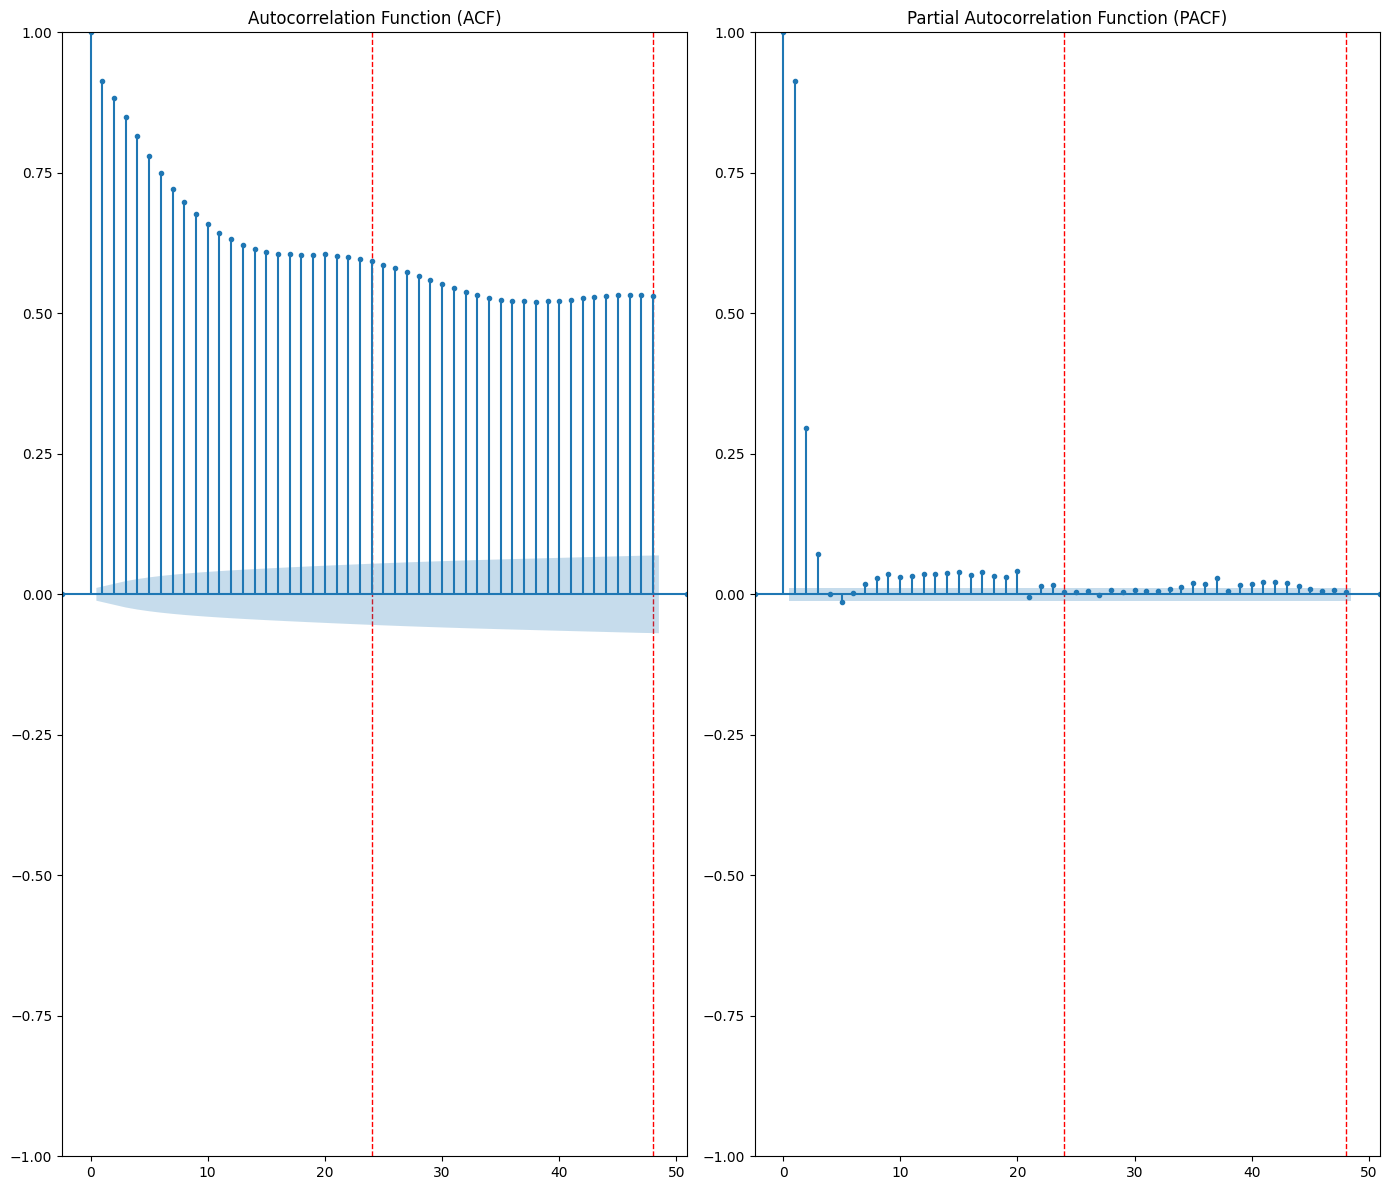

In [10]:
plot_acf_pacf(y_train_pow, 24, 48)

# Modelling

In [12]:
# AR Model based on PACF
for p in range(1,22):
    order = (p,0,0)
    modelling(
        order=order,
        exog=False,
        data_y_train_trans=y_train_pow,
        data_y_train=y_train_pow,
        data_y_test=y_test,
        lambda_opt=lambda_opt
    )


Testing ARIMA(1, 0, 0)
Fitting model...
Model fitted successfully in 0.97 seconds!
Training RMSE: 7650.6844, MAE: 7609.9348, MAPE: 92.62%
Testing RMSE: 40.6527, MAE: 31.4713, MAPE: 5.92%
Ljung-Box p-value: 0.000000
Lilliefors p-value: 0.001000
Model ARIMA(1, 0, 0) completed successfully!
Results saved to 03_Result_ARIMA.csv

Testing ARIMA(2, 0, 0)
Fitting model...
Model fitted successfully in 1.21 seconds!
Training RMSE: 7650.6052, MAE: 7609.9244, MAPE: 92.62%
Testing RMSE: 40.2857, MAE: 31.1082, MAPE: 5.87%
Ljung-Box p-value: 0.000000
Lilliefors p-value: 0.001000
Model ARIMA(2, 0, 0) completed successfully!
Results saved to 03_Result_ARIMA.csv

Testing ARIMA(3, 0, 0)
Fitting model...
Model fitted successfully in 2.81 seconds!
Training RMSE: 7650.6014, MAE: 7609.9246, MAPE: 92.62%
Testing RMSE: 40.2089, MAE: 31.0344, MAPE: 5.86%
Ljung-Box p-value: 0.000000
Lilliefors p-value: 0.001000
Model ARIMA(3, 0, 0) completed successfully!
Results saved to 03_Result_ARIMA.csv

Testing ARIMA(4, 0

In [14]:
# MA model
for q in range(1,22):
    order = (0,0,q)
    modelling(
        order=order,
        exog=False,
        data_y_train_trans=y_train_pow,
        data_y_train=y_train_pow,
        data_y_test=y_test,
        lambda_opt=lambda_opt
    )


Testing ARIMA(0, 0, 1)
Fitting model...
Model fitted successfully in 8.25 seconds!
Training RMSE: 7652.3886, MAE: 7609.5381, MAPE: 92.60%
Testing RMSE: 42.0778, MAE: 32.6378, MAPE: 6.09%
Ljung-Box p-value: 0.000000
Lilliefors p-value: 0.001000
Model ARIMA(0, 0, 1) completed successfully!
Results saved to 03_Result_ARIMA.csv

Testing ARIMA(0, 0, 2)
Fitting model...
Model fitted successfully in 13.03 seconds!
Training RMSE: 7651.7755, MAE: 7609.6469, MAPE: 92.61%
Testing RMSE: 41.9572, MAE: 32.5962, MAPE: 6.08%
Ljung-Box p-value: 0.000000
Lilliefors p-value: 0.001000
Model ARIMA(0, 0, 2) completed successfully!
Results saved to 03_Result_ARIMA.csv

Testing ARIMA(0, 0, 3)
Fitting model...
Model fitted successfully in 17.79 seconds!
Training RMSE: 7651.4679, MAE: 7609.7070, MAPE: 92.61%
Testing RMSE: 41.8575, MAE: 32.5579, MAPE: 6.08%
Ljung-Box p-value: 0.000000
Lilliefors p-value: 0.001000
Model ARIMA(0, 0, 3) completed successfully!
Results saved to 03_Result_ARIMA.csv

Testing ARIMA(0,

: 

In [13]:
compare = pd.read_csv('03_Result_ARIMA.csv')
compare.tail(10)

,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,MAE Training,MAPE Training,RMSE Testing,MAE Testing,MAPE Testing,Training Time (seconds)
11,"ARIMA(12, 0, 0)",Tidak,0.627902,Ya,0.001,Tidak,7650.6004,7609.9287,92.62,40.0366,30.7587,5.82,15.34
12,"ARIMA(13, 0, 0)",Tidak,0.588338,Ya,0.001,Tidak,7650.6002,7609.9298,92.62,40.0101,30.7001,5.81,17.97
13,"ARIMA(14, 0, 0)",Tidak,0.556526,Ya,0.001,Tidak,7650.5999,7609.9307,92.62,39.9855,30.6530,5.80,20.38
14,"ARIMA(15, 0, 0)",Tidak,0.611289,Ya,0.001,Tidak,7650.5996,7609.9316,92.62,39.9566,30.5817,5.79,21.93
15,"ARIMA(16, 0, 0)",Tidak,0.736685,Ya,0.001,Tidak,7650.5995,7609.9325,92.62,39.9340,30.5059,5.78,26.29
16,"ARIMA(17, 0, 0)",Tidak,0.900131,Ya,0.001,Tidak,7650.5992,7609.9335,92.62,39.9025,30.3956,5.76,27.92
17,"ARIMA(18, 0, 0)",Tidak,0.977142,Ya,0.001,Tidak,7650.5991,7609.9344,92.62,39.8731,30.2577,5.74,28.75
18,"ARIMA(19, 0, 0)",Tidak,0.997565,Ya,0.001,Tidak,7650.5991,7609.9352,92.62,39.8438,30.0845,5.72,41.14
19,"ARIMA(20, 0, 0)",Tidak,0.999988,Ya,0.001,Tidak,7650.5988,7609.9350,92.62,39.7958,29.7851,5.67,36.13
20,"ARIMA(21, 0, 0)",Tidak,0.999971,Ya,0.001,Tidak,7650.5987,7609.9347,92.62,39.8047,29.8260,5.68,49.23


In [11]:
# ARIMA model based on ACF PACF (q: dies down; p: cut off at lag-3)
ar_configs = [
    {'name': 'ARIMA(1,0,0)', 'model_type': 'ARIMA', 'order': (1,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,0)', 'model_type': 'ARIMA', 'order': (2,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,0)', 'model_type': 'ARIMA', 'order': (3,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,0)', 'model_type': 'ARIMA', 'order': (4,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,0)', 'model_type': 'ARIMA', 'order': (5,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(6,0,0)', 'model_type': 'ARIMA', 'order': (6,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(7,0,0)', 'model_type': 'ARIMA', 'order': (7,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(8,0,0)', 'model_type': 'ARIMA', 'order': (8,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(9,0,0)', 'model_type': 'ARIMA', 'order': (9,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(10,0,0)', 'model_type': 'ARIMA', 'order': (10,0,0), 'seasonal_order': None, 'exog': False},
]
ar_comparison = modelling (ar_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ar_comparison


Testing ARIMA(1,0,0)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Manggarai (air)   No. Observations:                29662
Model:                 ARIMA(1, 0, 0)   Log Likelihood             -211985.459
Date:                Wed, 28 May 2025   AIC                         423976.917
Time:                        10:47:01   BIC                         424001.810
Sample:                    10-16-2021   HQIC                        423984.909
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7557.9310     30.184    250.392      0.000    7498.771    7617.091
ar.L1          0.9133      0.001   1052.321      0.000       0.91

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Manggarai (air),"ARIMA(1,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,21.4668,40.7089
1,Manggarai (air),"ARIMA(2,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,19.8556,40.3410
2,Manggarai (air),"ARIMA(3,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,19.7526,40.2858
3,Manggarai (air),"ARIMA(4,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,19.7515,40.2836
4,Manggarai (air),"ARIMA(5,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,19.7512,40.2918
5,Manggarai (air),"ARIMA(6,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,19.7511,40.2889
6,Manggarai (air),"ARIMA(7,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,19.7487,40.2744
7,Manggarai (air),"ARIMA(8,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,19.7414,40.2510
8,Manggarai (air),"ARIMA(9,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,19.7293,40.2251
9,Manggarai (air),"ARIMA(10,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,19.7197,40.2040


In [12]:
# Try MA models
ma_configs = [
    {'name': 'ARIMA(0,0,1)', 'model_type': 'ARIMA', 'order': (0,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,2)', 'model_type': 'ARIMA', 'order': (0,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,3)', 'model_type': 'ARIMA', 'order': (0,0,3), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,4)', 'model_type': 'ARIMA', 'order': (0,0,4), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,5)', 'model_type': 'ARIMA', 'order': (0,0,5), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,6)', 'model_type': 'ARIMA', 'order': (0,0,6), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,7)', 'model_type': 'ARIMA', 'order': (0,0,7), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,8)', 'model_type': 'ARIMA', 'order': (0,0,8), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,9)', 'model_type': 'ARIMA', 'order': (0,0,9), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,10)', 'model_type': 'ARIMA', 'order': (0,0,10), 'seasonal_order': None, 'exog': False},
]
ma_comparison = modelling (ma_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ma_comparison


Testing ARIMA(0,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Manggarai (air)   No. Observations:                29662
Model:                 ARIMA(0, 0, 1)   Log Likelihood             -227334.312
Date:                Wed, 28 May 2025   AIC                         454674.623
Time:                        10:49:22   BIC                         454699.516
Sample:                    10-16-2021   HQIC                        454682.614
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7557.9375      5.111   1478.744      0.000    7547.920    7567.955
ma.L1          0.6939      0.001    624.292      0.000       0.69

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Manggarai (air),"ARIMA(0,0,1)",Ya,0.000000,Tidak,0.001000,Tidak,31.9612,42.5656
1,Manggarai (air),"ARIMA(0,0,2)",Ya,0.000000,Tidak,0.001000,Tidak,27.3017,42.4171
2,Manggarai (air),"ARIMA(0,0,3)",Ya,0.000000,Tidak,0.001000,Tidak,24.9531,42.2806
3,Manggarai (air),"ARIMA(0,0,4)",Ya,0.000000,Tidak,0.001000,Tidak,23.4915,42.1536
4,Manggarai (air),"ARIMA(0,0,5)",Ya,0.000000,Tidak,0.001000,Tidak,22.5255,42.0283
5,Manggarai (air),"ARIMA(0,0,6)",Ya,0.000000,Tidak,0.001000,Tidak,21.8819,41.9327
6,Manggarai (air),"ARIMA(0,0,7)",Ya,0.000000,Tidak,0.001000,Tidak,21.4373,41.8236
7,Manggarai (air),"ARIMA(0,0,8)",Ya,0.000000,Tidak,0.001000,Tidak,21.1194,41.7449
8,Manggarai (air),"ARIMA(0,0,9)",Ya,0.000000,Tidak,0.001000,Tidak,20.8919,41.6753
9,Manggarai (air),"ARIMA(0,0,10)",Ya,0.000000,Tidak,0.001000,Tidak,20.7075,41.6008


In [13]:
# Try MA models
ma2_configs = [
    {'name': 'ARIMA(0,0,11)', 'model_type': 'ARIMA', 'order': (0,0,11), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,12)', 'model_type': 'ARIMA', 'order': (0,0,12), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,13)', 'model_type': 'ARIMA', 'order': (0,0,13), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,14)', 'model_type': 'ARIMA', 'order': (0,0,14), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,15)', 'model_type': 'ARIMA', 'order': (0,0,15), 'seasonal_order': None, 'exog': False}
]
ma2_comparison = modelling (ma2_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ma2_comparison


Testing ARIMA(0,0,11)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Manggarai (air)   No. Observations:                29662
Model:                ARIMA(0, 0, 11)   Log Likelihood             -211786.405
Date:                Wed, 28 May 2025   AIC                         423598.810
Time:                        11:02:49   BIC                         423706.679
Sample:                    10-16-2021   HQIC                        423633.439
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7557.9355     15.409    490.487      0.000    7527.734    7588.137
ma.L1          0.6832      0.001    802.100      0.000       0.6

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Manggarai (air),"ARIMA(0,0,11)",Ya,0.000000,Tidak,0.001000,Tidak,20.5692,41.5379
1,Manggarai (air),"ARIMA(0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,20.4521,41.4726
2,Manggarai (air),"ARIMA(0,0,13)",Ya,0.000000,Tidak,0.001000,Tidak,20.3583,41.4187
3,Manggarai (air),"ARIMA(0,0,14)",Ya,0.000000,Tidak,0.001000,Tidak,20.2810,41.3670
4,Manggarai (air),"ARIMA(0,0,15)",Ya,0.000000,Tidak,0.001000,Tidak,20.2094,41.3211


In [15]:
# Try MA models
ma3_configs = [
    {'name': 'ARIMA(0,0,16)', 'model_type': 'ARIMA', 'order': (0,0,16), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,17)', 'model_type': 'ARIMA', 'order': (0,0,17), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,18)', 'model_type': 'ARIMA', 'order': (0,0,18), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,19)', 'model_type': 'ARIMA', 'order': (0,0,19), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,20)', 'model_type': 'ARIMA', 'order': (0,0,20), 'seasonal_order': None, 'exog': False},
]
ma3_comparison = modelling (ma3_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ma3_comparison


Testing ARIMA(0,0,16)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Manggarai (air)   No. Observations:                29662
Model:                ARIMA(0, 0, 16)   Log Likelihood             -211142.733
Date:                Wed, 28 May 2025   AIC                         422321.466
Time:                        11:17:40   BIC                         422470.824
Sample:                    10-16-2021   HQIC                        422369.415
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7557.9347     18.906    399.766      0.000    7520.880    7594.990
ma.L1          0.6527      0.001    772.664      0.000       0.6

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Manggarai (air),"ARIMA(0,0,16)",Ya,0.000000,Tidak,0.001000,Tidak,20.1605,41.2887
1,Manggarai (air),"ARIMA(0,0,17)",Ya,0.000000,Tidak,0.001000,Tidak,20.1185,41.2577
2,Manggarai (air),"ARIMA(0,0,18)",Ya,0.000000,Tidak,0.001000,Tidak,20.0978,41.2278
3,Manggarai (air),"ARIMA(0,0,19)",Ya,0.000000,Tidak,0.001000,Tidak,20.0919,41.2053
4,Manggarai (air),"ARIMA(0,0,20)",Ya,0.000000,Tidak,0.001000,Tidak,20.0408,41.1464


In [16]:
compare = pd.concat([ar_comparison,
                     ma_comparison,
                     ma2_comparison,
                     ma3_comparison
                     ])
compare.to_csv(f'model_comparison_{data_y_train.name}_results.csv')

In [11]:
compare = pd.read_csv(f'model_comparison_{data_y_train.name}_results.csv', index_col=0)
compare

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Manggarai (air),"ARIMA(1,0,0)",Ya,0.0,Tidak,0.001,Tidak,21.4668,40.7089
1,Manggarai (air),"ARIMA(2,0,0)",Ya,0.0,Tidak,0.001,Tidak,19.8556,40.3410
2,Manggarai (air),"ARIMA(3,0,0)",Ya,0.0,Tidak,0.001,Tidak,19.7526,40.2858
3,Manggarai (air),"ARIMA(4,0,0)",Tidak,0.0,Tidak,0.001,Tidak,19.7515,40.2836
4,Manggarai (air),"ARIMA(5,0,0)",Tidak,0.0,Tidak,0.001,Tidak,19.7512,40.2918
5,Manggarai (air),"ARIMA(6,0,0)",Tidak,0.0,Tidak,0.001,Tidak,19.7511,40.2889
6,Manggarai (air),"ARIMA(7,0,0)",Tidak,0.0,Tidak,0.001,Tidak,19.7487,40.2744
7,Manggarai (air),"ARIMA(8,0,0)",Tidak,0.0,Tidak,0.001,Tidak,19.7414,40.2510
8,Manggarai (air),"ARIMA(9,0,0)",Tidak,0.0,Tidak,0.001,Tidak,19.7293,40.2251
9,Manggarai (air),"ARIMA(10,0,0)",Tidak,0.0,Tidak,0.001,Tidak,19.7197,40.2040


In [12]:
# SARIMA
sar_configs = [
    {'name': 'SARIMA(1,0,0)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (1,0,0), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(2,0,0)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (2,0,0), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(3,0,0)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (3,0,0), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(4,0,0)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (4,0,0), 'seasonal_order': (1,0,0,24), 'exog': False},
    {'name': 'SARIMA(5,0,0)x(1,0,0,24)', 'model_type': 'SARIMA', 'order': (5,0,0), 'seasonal_order': (1,0,0,24), 'exog': False},
]
sar_comparison = modelling (sar_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
sar_comparison


Testing SARIMA(1,0,0)x(1,0,0,24)
Fitting model...
Error fitting SARIMA(1,0,0)x(1,0,0,24): LU decomposition error.
Error cleanup: 0 objects collected

Testing SARIMA(2,0,0)x(1,0,0,24)
Fitting model...


: 